In [1]:
########################################
#             PATH SETUP
########################################

import sys
import os
sys.path.insert(0, os.path.abspath("."))

########################################
#             LIBRERIES SETUP
########################################
import numpy as np
import matplotlib.pyplot as plt
from lemer.rngs import MultiStreamRNG
from lemer.rvms import *

In [13]:
print("hello i am under the water plz help me")

hello i am under the water plz help me


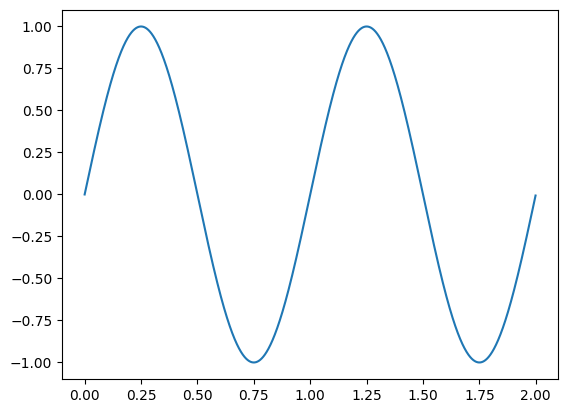

In [2]:
t = np.linspace(0,2,2000,endpoint=False)
y=np.sin(2*np.pi*t)
plt.plot(t,y)
plt.show()

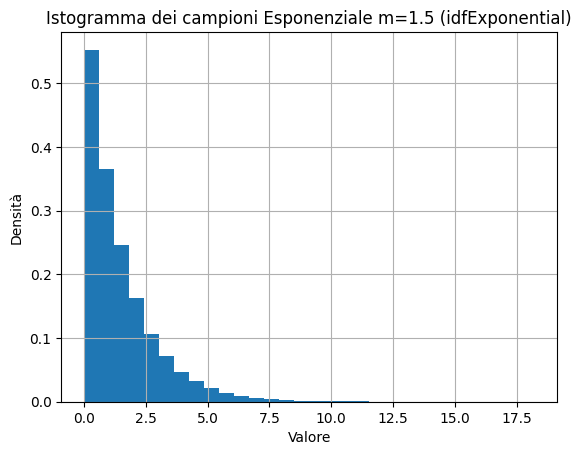

In [2]:
# Parametri della distribuzione esponenziale
m = 1.5  # media
n_samples = 50000

# Generazione dei campioni usando idfExponential
stream = MultiStreamRNG(42)
samples = [idfExponential(m, stream.random()) for _ in range(n_samples)]
samples = np.array(samples)

# Plot dell'istogramma
plt.figure()
plt.hist(samples, bins=30, density=True)
plt.title('Istogramma dei campioni Esponenziale m=1.5 (idfExponential)')
plt.xlabel('Valore')
plt.ylabel('Densità')
plt.grid(True)
plt.show()


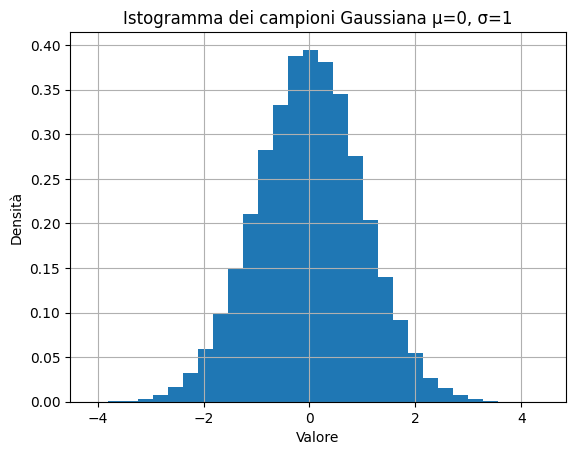

In [3]:
# Parametri della gaussiana
n_samples = 100000

# Generazione dei campioni con numpy per riproducibilità
rng = MultiStreamRNG(1234)
samples = [idfNormal(m=0, s=1, u=stream.random()) for _ in range(n_samples)]
# Plot dell'istogramma
plt.figure()
plt.hist(samples, bins=30, density=True)
plt.title('Istogramma dei campioni Gaussiana μ=0, σ=1')
plt.xlabel('Valore')
plt.ylabel('Densità')
plt.grid(True)
plt.show()


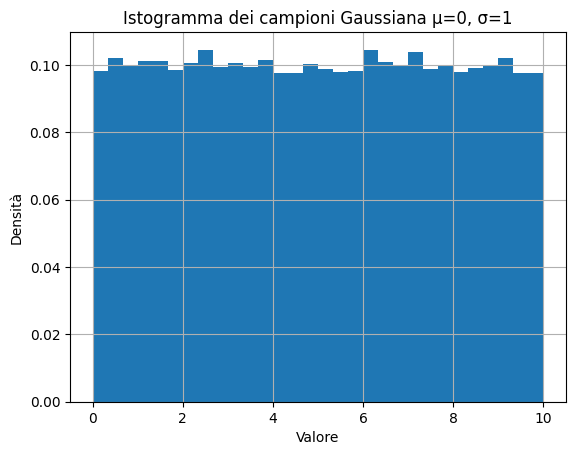

In [4]:
n_samples = 100000

# Generazione dei campioni con numpy per riproducibilità
rng = MultiStreamRNG(1234)
samples = [idfUniform(a=0, b=10,u=stream.random()) for _ in range(n_samples)]
# Plot dell'istogramma
plt.figure()
plt.hist(samples, bins=30, density=True)
plt.title('Istogramma dei campioni Gaussiana μ=0, σ=1')
plt.xlabel('Valore')
plt.ylabel('Densità')
plt.grid(True)
plt.show()
